<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-12-31 15:58:05--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.08s   

2020-12-31 15:58:06 (266 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['education'].replace({'Bechalor': 'Bachelor'}, inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y
!pip install seaborn

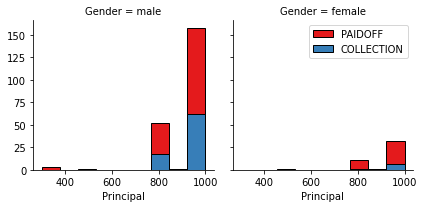

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

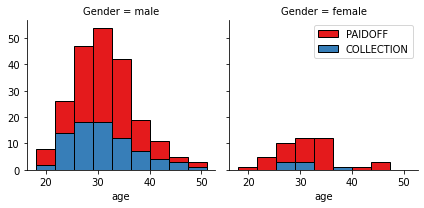

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

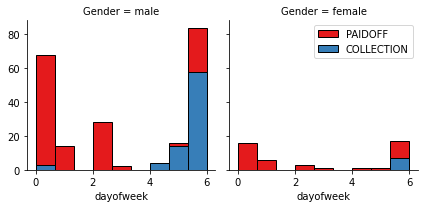

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bachelor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bachelor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

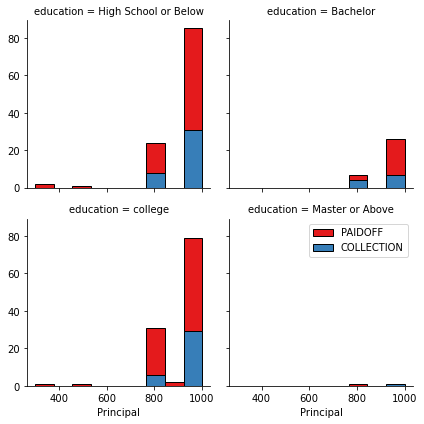

In [15]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="education", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bachelor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
le = preprocessing.LabelEncoder()
le.fit(['PAIDOFF','COLLECTION'])
y = le.transform(y) 
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [23]:
# Find best K
K_test = 25
mean_acc = np.zeros((K_test-1))
std_acc = np.zeros((K_test-1))

for n in range(1, K_test):    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat  = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

K_best=mean_acc.argmax()+1
KNN_clf = KNeighborsClassifier(n_neighbors = K_best).fit(X_train,y_train)

print( "The best accuracy is ", mean_acc.max(), "+/-", std_acc[mean_acc.argmax()], "with k =", K_best)

The best accuracy is  0.7857142857142857 +/- 0.049043325880399655 with k = 7


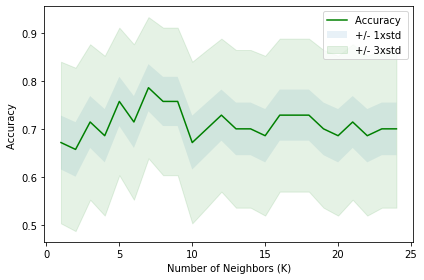

In [24]:
plt.plot(range(1,K_test),mean_acc,'g')
plt.fill_between(range(1,K_test),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,K_test),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

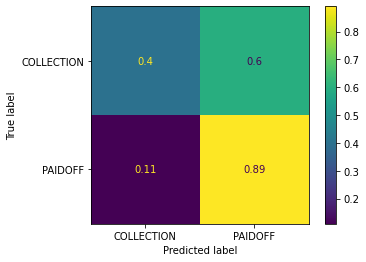

In [25]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(KNN_clf, X_test, y_test,
                             display_labels=['COLLECTION', 'PAIDOFF'],
                             normalize='true')

# Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [27]:
Max_Depth = 10
mean_train_acc = np.zeros((Max_Depth-1))
std_train_acc = np.zeros((Max_Depth-1))
mean_acc = np.zeros((Max_Depth-1))
std_acc = np.zeros((Max_Depth-1))

# Here I only use 'entropy'
for n in range(1, Max_Depth):    
    #Train Model and Predict
    Tree = DecisionTreeClassifier(criterion="entropy", max_depth = n, random_state = 0)
    Tree.fit(X_train, y_train)
    # accuracy on train set    
    yhat = Tree.predict(X_train)
    mean_train_acc[n-1] = metrics.accuracy_score(y_train, yhat)
    std_train_acc[n-1]=np.std(yhat==y_train)/np.sqrt(yhat.shape[0])
    # accuracy on test set
    yhat = Tree.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat) 
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

Depth_best = mean_acc.argmax()+1
print( "The best accuracy is ", mean_acc.max(), "+/-", std_acc[mean_acc.argmax()], "with max depth =", Depth_best)

The best accuracy is  0.7857142857142857 +/- 0.049043325880399655 with max depth = 1


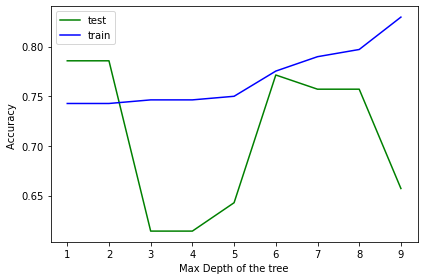

In [28]:
plt.plot(range(1,Max_Depth),mean_acc,'g', label='test')
plt.plot(range(1,Max_Depth),mean_train_acc, label='train', color='blue')
plt.legend()
plt.ylabel('Accuracy ')
plt.xlabel('Max Depth of the tree')

plt.tight_layout()
plt.show()

In [29]:
# Max depth = 1 or 2 doesn't seem to make sense. But max depth = 6 probably will work well
Depth_best = 6 
Tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth = Depth_best)
Tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

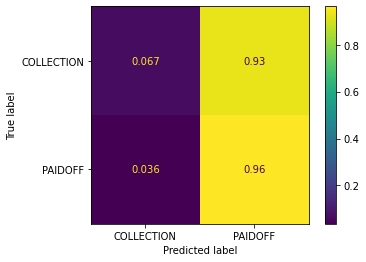

In [30]:
# Confusion matrix
disp = plot_confusion_matrix(Tree_clf, X_test, y_test,
                             display_labels=['COLLECTION', 'PAIDOFF'],
                             normalize='true')
# Seem to give more false PAIDOFF-true COLLECTION results than KNN

# Support Vector Machine

In [31]:
from sklearn import svm

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
param_grid = [  
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['sigmoid']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['poly'], 'degree': [2,3,4]},
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
 ]

SVM_clf = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=4)
SVM_clf.fit(X_train, y_train)

yhat = SVM_clf.predict(X_test)

print(classification_report(y_test, yhat))

print ("Best Score for SVM using grid search:", SVM_clf.best_score_)
print ("Best params for SVM using grid search:", SVM_clf.best_params_)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.79      1.00      0.88        55

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Best Score for SVM using grid search: 0.7427536231884058
Best params for SVM using grid search: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


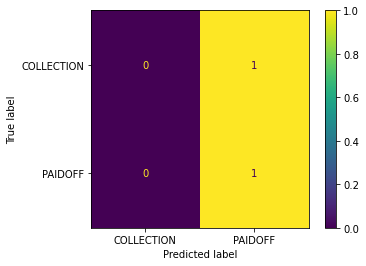

In [33]:
# Confusion matrix
disp = plot_confusion_matrix(SVM_clf, X_test, y_test,
                             display_labels=['COLLECTION', 'PAIDOFF'],
                             normalize='true')
# Confusion matrix doesn't look good -- 100% false for true COLLECTION

In [34]:
# Let's just tune kernel and see if I get something more reasonable
params = ['rbf', 'linear', 'sigmoid', 'poly 2', 'poly 3', 'poly 4']
mean_acc = np.zeros((len(params)))
std_acc = np.zeros((len(params)))

for n in range(0,len(params)):
    if (len(params[n].split())>1):
        tmp = params[n].split()
        SVM_clf = svm.SVC(kernel=tmp[0], degree=int(tmp[1]))
    else:
        SVM_clf = svm.SVC(kernel=params[n])
    
    SVM_clf.fit(X_train, y_train)
    yhat = SVM_clf.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

Kernel_best = ''
Degree = 0
if (len(params[mean_acc.argmax()].split())>1):
    Kernel_best = params[mean_acc.argmax()].split()[0]
    Degree = int(params[mean_acc.argmax()].split()[1])
    SVM_clf = svm.SVC(kernel=Kernel_best, degree=Degree)
else:
    Kernel_best=params[mean_acc.argmax()]
    SVM_clf = svm.SVC(kernel=Kernel_best)
    
SVM_clf.fit(X_train, y_train)
print( "The best accuracy is ", mean_acc.max(), "+/-", std_acc[mean_acc.argmax()], "with kernel =", Kernel_best)

The best accuracy is  0.7857142857142857 +/- 0.049043325880399655 with kernel = rbf


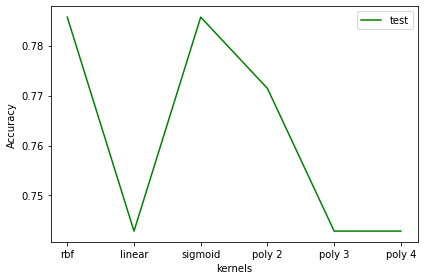

In [35]:
plt.plot(range(0,(len(params))), mean_acc,'g', label='test')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('kernels')

locs = np.linspace(0,len(params)-1, num=len(params))
plt.xticks(locs, params)

plt.tight_layout()
plt.show()

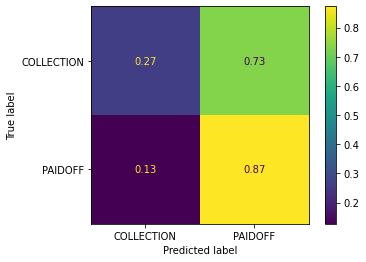

In [36]:
# Confusion matrix
disp = plot_confusion_matrix(SVM_clf, X_test, y_test,
                             display_labels=['COLLECTION', 'PAIDOFF'],
                             normalize='true')
# Confusion matrix still doesn't look good -- 73% of true COLLECTION were falsely marked as PAIDOFF
# However, it's better than 100% -- I will leave this as the final model

# Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
# [0.001, 0.01, 0.1, 1]
# [1, 10, 100, 1000]
param_grid = [
  {'C': [1, 10, 100, 1000], 'solver': ['newton-cg']},
  {'C': [1, 10, 100, 1000], 'solver': ['lbfgs']},
  {'C': [1, 10, 100, 1000], 'solver': ['liblinear'], 'penalty':['l1']},
  {'C': [1, 10, 100, 1000], 'solver': ['liblinear'], 'penalty':['l2']},
  {'C': [1, 10, 100, 1000], 'solver': ['sag'], 'max_iter':[5000]},
  {'C': [1, 10, 100, 1000], 'solver': ['saga'], 'penalty':['l1'], 'max_iter':[5000]},
  {'C': [1, 10, 100, 1000], 'solver': ['saga'], 'penalty':['l2'], 'max_iter':[5000]},
  {'C': [1, 10, 100, 1000], 'solver': ['saga'], 'penalty':['elasticnet'], 'max_iter':[5000]},
 ]

LR_clf = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5)
LR_clf.fit(X_train, y_train)

yhat = LR_clf.predict(X_test)

print(classification_report(y_test, yhat))

print ("Best Score for LogReg using grid search:", LR_clf.best_score_)
print ("Best params for LogReg using grid search:", LR_clf.best_params_)

              precision    recall  f1-score   support

           0       0.29      0.13      0.18        15
           1       0.79      0.91      0.85        55

    accuracy                           0.74        70
   macro avg       0.54      0.52      0.51        70
weighted avg       0.68      0.74      0.70        70

Best Score for LogReg using grid search: 0.7572077922077922
Best params for LogReg using grid search: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1313, in fit
    " got (l1_ratio=%r)" % self.l1_ratio)
ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

  FitFailedWarning)


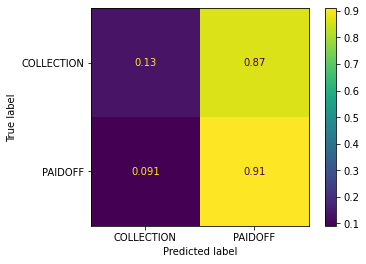

In [39]:
disp = plot_confusion_matrix(LR_clf, X_test, y_test,
                             display_labels=['COLLECTION', 'PAIDOFF'],
                             normalize='true')
# As in the case of SVM, correlation matrix doesn't look too good. The misidentification of COLLECTION is even higher here

# Model Evaluation using Test set

In [40]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [41]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-12-31 15:58:22--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-12-31 15:58:23 (34.8 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [42]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [43]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['education'].replace({'Bechalor': 'Bachelor'}, inplace=True)
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)
Feature_test.head()

,Principal,terms,age,Gender,weekend,Bachelor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [44]:
X_final_test= preprocessing.StandardScaler().fit(Feature_test).transform(Feature_test)
y_final_test= test_df['loan_status'].values
y_final_test = le.transform(y_final_test) 

In [45]:
# KNN
y_hat_knn = KNN_clf.predict(X_final_test)
print('Results for KNN')
print('Jaccard similarity score:', jaccard_score(y_final_test, y_hat_knn))
print('F1 score:', f1_score(y_final_test, y_hat_knn, average='weighted'))

Results for KNN
Jaccard similarity score: 0.6538461538461539
F1 score: 0.6328400281888654


In [46]:
# Decision Tree
y_hat_tree = Tree_clf.predict(X_final_test)
print('Results for Decision Tree')
print('Jaccard similarity score:', jaccard_score(y_final_test, y_hat_tree))
print('F1 score:', f1_score(y_final_test, y_hat_tree, average='weighted'))

Results for Decision Tree
Jaccard similarity score: 0.7115384615384616
F1 score: 0.6704776923582364


In [47]:
# SVM
y_hat_svm = SVM_clf.predict(X_final_test)
print('Results for SVM')
print('Jaccard similarity score:', jaccard_score(y_final_test, y_hat_svm))
print('F1 score:', f1_score(y_final_test, y_hat_svm, average='weighted'))

Results for SVM
Jaccard similarity score: 0.78
F1 score: 0.7583503077293734


In [48]:
# Logistic Regression
y_hat_lr = LR_clf.predict(X_final_test)
y_hat_lr_prob = LR_clf.predict_proba(X_final_test)
print('Results for LoGReg')
print('Jaccard similarity score:', jaccard_score(y_final_test, y_hat_lr))
print('F1 score:', f1_score(y_final_test, y_hat_lr, average='weighted'))
print('LogLoss score:', log_loss(y_final_test, y_hat_lr_prob))

Results for LoGReg
Jaccard similarity score: 0.7547169811320755
F1 score: 0.6717642373556352
LogLoss score: 0.4729265250235294


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.65    | 0.63     | NA      |
| Decision Tree      | 0.71    | 0.67     | NA      |
| SVM                | 0.78    | 0.75     | NA      |
| LogisticRegression | 0.75    | 0.67     | 0.47    |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>